# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1]:
%pip install fast_ml    ## Required for constant feature identification package

from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [4]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No,No,Modified


In [5]:
lead_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [6]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20) and (df[col].dtype != np.float64):
            d_categories['int_cat'].append(col)
        else:
            
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [7]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [8]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID','Lead Number', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [9]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [10]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [11]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes

,lead_origin,lead_source,do_not_email,do_not_call,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,country,specialization,info_abt_x_edu,curr_occupation,reason_behind_course,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,more_course_updates,tags,lead_quality,supply_chain_info,get_dm,lead_profile,city,asym_activ_idx,asym_prof_idx,asym_activ_score,asym_prof_score,avail_free_copy
0,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No


lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

In [12]:
print(f'{lead_score_df.shape}, {lead_score_df.size}')

(9240, 33), 304920


##### Constant Feature Identification

In [13]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

,Desc,Var,Value,Perc
0,Constant,magazine,No,100.000
1,Constant,more_course_updates,No,100.000
2,Constant,supply_chain_info,No,100.000
3,Constant,get_dm,No,100.000
4,Quasi Constant,x_education_forums,No,99.989
5,Quasi Constant,newspaper,No,99.989
6,Quasi Constant,do_not_call,No,99.978
7,Quasi Constant,newspaper_article,No,99.978
8,Quasi Constant,digital_advertisement,No,99.957
9,Quasi Constant,through_recommendations,No,99.924


"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

In [14]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search',], axis=1)

In [15]:
lead_score_df['reason_behind_course'].value_counts(normalize=True)*100
lead_score_df = lead_score_df.drop(['reason_behind_course'], axis=1)

lead_score_df[['country']].value_counts(normalize=True)*100
lead_score_df = lead_score_df.drop(['country'], axis=1)

reason_behind_course
Better Career Prospects     99.954
Flexibility & Convenience    0.031
Other                        0.015
Name: proportion, dtype: float64

country             
India                  95.766
United States           1.018
United Arab Emirates    0.782
Singapore               0.354
Saudi Arabia            0.310
United Kingdom          0.221
Australia               0.192
Qatar                   0.148
Bahrain                 0.103
Hong Kong               0.103
France                  0.089
Oman                    0.089
unknown                 0.074
Kuwait                  0.059
Nigeria                 0.059
South Africa            0.059
Germany                 0.059
Canada                  0.059
Sweden                  0.044
Uganda                  0.030
Philippines             0.030
Asia/Pacific Region     0.030
Italy                   0.030
Ghana                   0.030
China                   0.030
Belgium                 0.030
Bangladesh              0.030
Netherlands             0.030
Malaysia                0.015
Liberia                 0.015
Russia                  0.015
Kenya                   0.015
Indonesia          

##### Missing Value Imputation

In [16]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

lead_quality       51.591
asym_activ_idx     45.649
asym_prof_score    45.649
asym_activ_score   45.649
asym_prof_idx      45.649
tags               36.288
lead_profile       29.318
curr_occupation    29.113
info_abt_x_edu     23.885
specialization     15.563
city               15.368
totalvisits         1.483
pg_view_pv          1.483
last_activity       1.115
lead_source         0.390
dtype: float64

In [17]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

tags              36.288
lead_profile      29.318
curr_occupation   29.113
info_abt_x_edu    23.885
specialization    15.563
city              15.368
totalvisits        1.483
pg_view_pv         1.483
last_activity      1.115
lead_source        0.390
dtype: float64

In [18]:
show_stats(lead_score_df,['tags','specialization'])

Total Nulls: 3353,
Mode: Will revert after reading the email

Unique: ['Interested in other courses' 'Ringing'
 'Will revert after reading the email' nan 'Lost to EINS'
 'In confusion whether part time or DLP' 'Busy' 'switched off'
 'in touch with EINS' 'Already a student' 'Diploma holder (Not Eligible)'
 'Graduation in progress' 'Closed by Horizzon' 'number not provided'
 'opp hangup' 'Not doing further education' 'invalid number'
 'wrong number given' 'Interested  in full time MBA' 'Still Thinking'
 'Lost to Others' 'Shall take in the next coming month' 'Lateral student'
 'Interested in Next batch' 'Recognition issue (DEC approval)'
 'Want to take admission but has financial problems'
 'University not recognized']

ValueCounts: tags
Will revert after reading the email   35.196
Ringing                               20.435
Interested in other courses            8.714
Already a student                      7.899
Closed by Horizzon                     6.081
Name: proportion, dtype: float

In [19]:
# replace select string with nan
lead_score_df[['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']] = lead_score_df[['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']].replace(to_replace=['select', 'Select', np.nan], value='unknown') 

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

In [20]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

In [21]:
# convert dtypes
# Convert the data type of certain features from object to category type
obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [22]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 60:
        if lead_score_df[i].isna().sum()>0:
            print(i)
            lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [23]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

In [24]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
# univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- The converter column has more ones than zeros
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between zero and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between zero and 20

#####

In [25]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
# univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users are by originated landing page following which the apis have 38 of leeds
 - When it comes to lead origin conversion rates lead add form has higher conversion rates holistically all have similar probability rate
 
 - When it comes to lead source 30 are from google twenty seven percent are from direct traffic 19 are from olak chat
 
 - For the do not email feature 90 of them chose no while 7 of them chose yes therefore majority of them are interested in the edtech platform
 - Also the people who have said no also the users who said no have a higher percent of conversion rate
  
 - The last activity of majority of the users say 38 of users are email opened followed by sms sent therefore we can say that
 - Majority of the users are active on email conversations
  
 - Majority of the users are from india
 - We can we can assume that air tech has a higher popularity in india or higher interest in india higher demand in india
 
 - Among the employed users most of the interested users have finance management as a specialization followed by human resource management and marketing management almost all specialization has a similar conversion rate
 
 - Majority of the users are unemployed followed by working professionals
 - Working professionals have a higher conversion rates while the user count is low in comparison to unemployed
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course
 
 - The majority of the leads have been tagged under will revert after reading the email
 
 - Maximum number of leads have been from the city of mumbai followed by thane almost all categories have similar probabilities of conversion
  
 - 90 of the leads have opted not to free copy of the interview while 31 are opted for interview copy
 

####

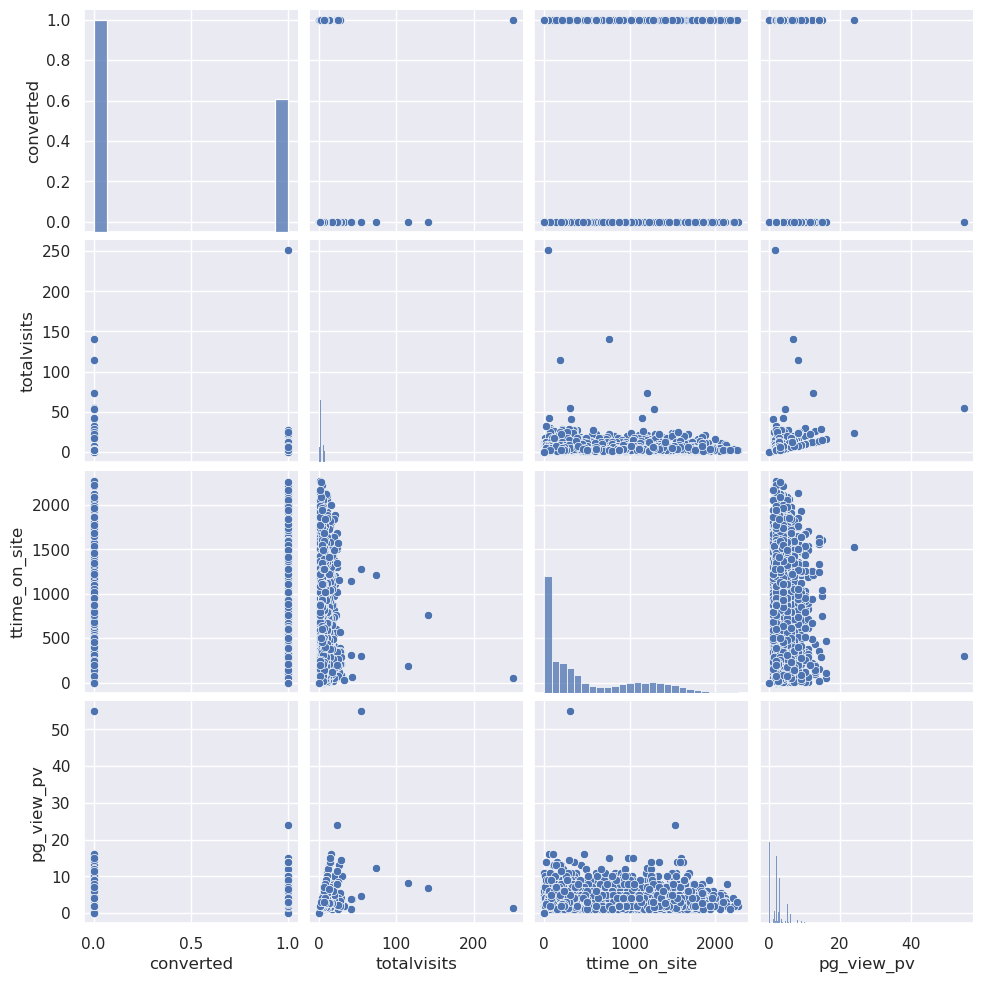

In [26]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit

sns.pairplot(lead_score_df)
plt.show();

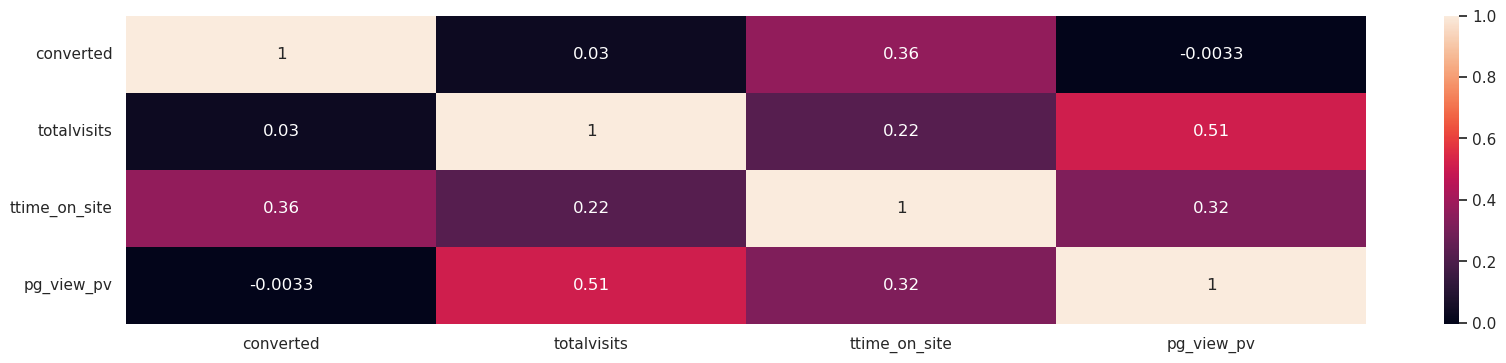

In [27]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

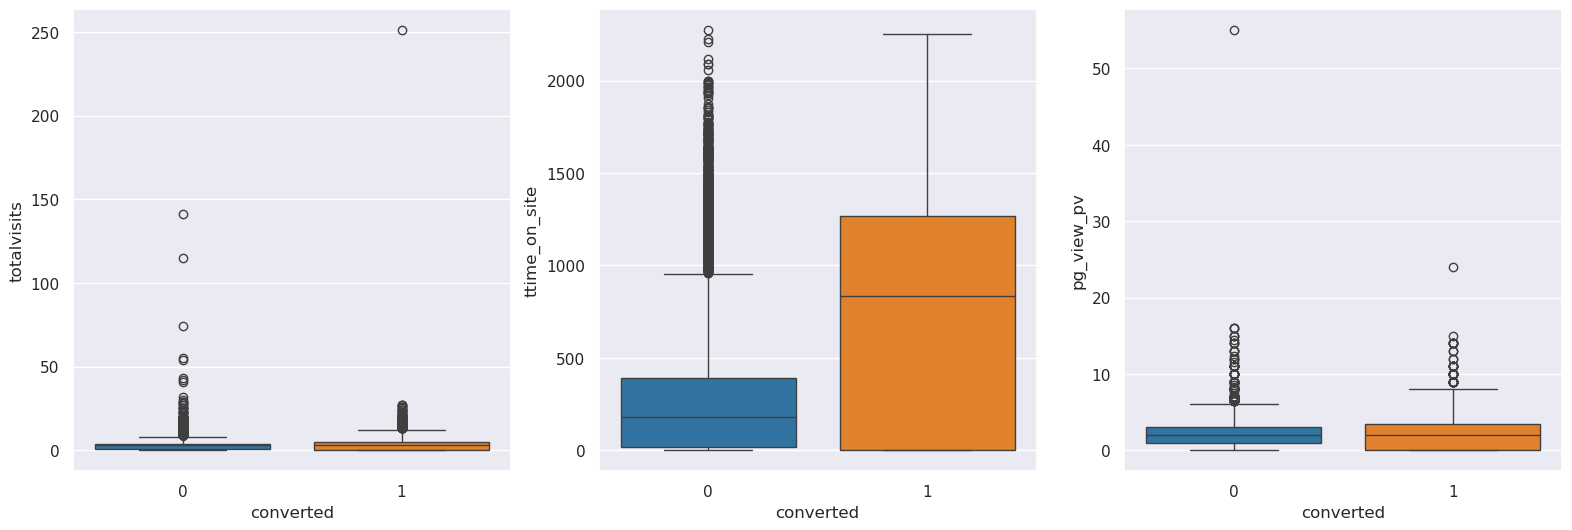

In [28]:
# # Boxplots - numerical features against target

axs = 141
plt.figure(figsize=(26, 6))
for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
    plt.subplot(axs)
    sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
    axs += 1
plt.show();

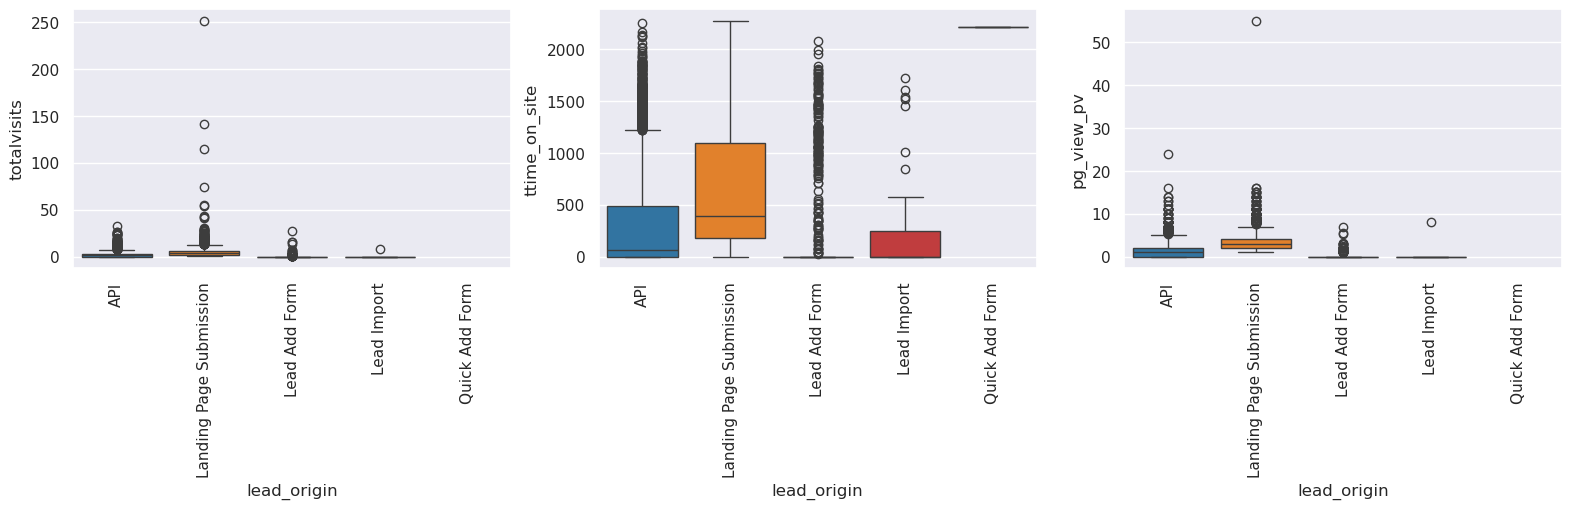

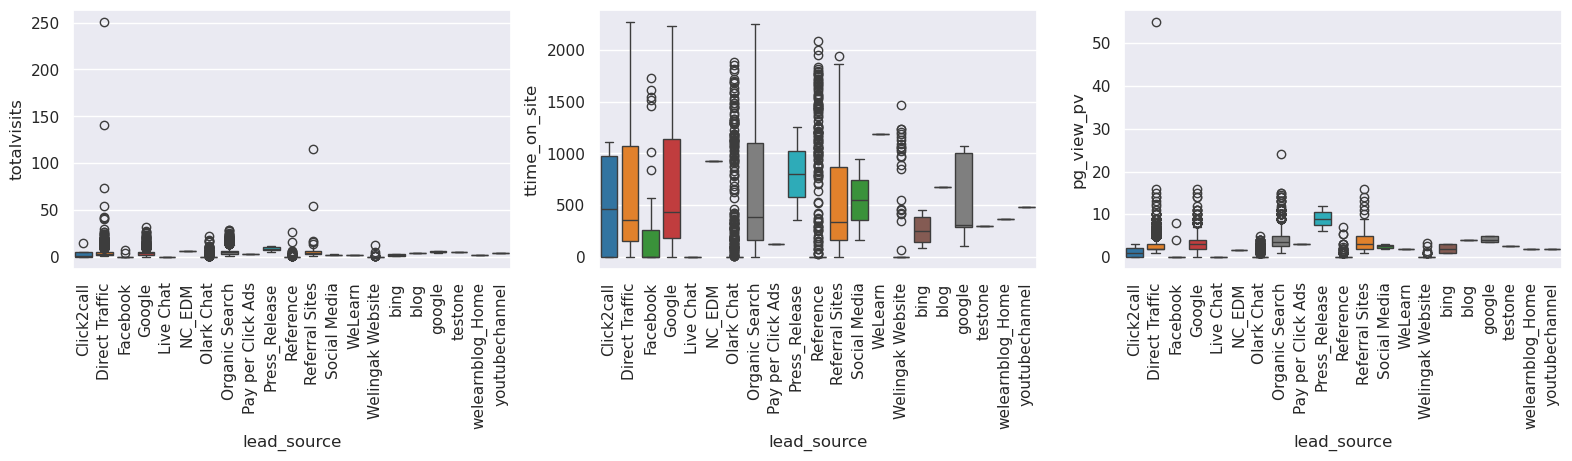

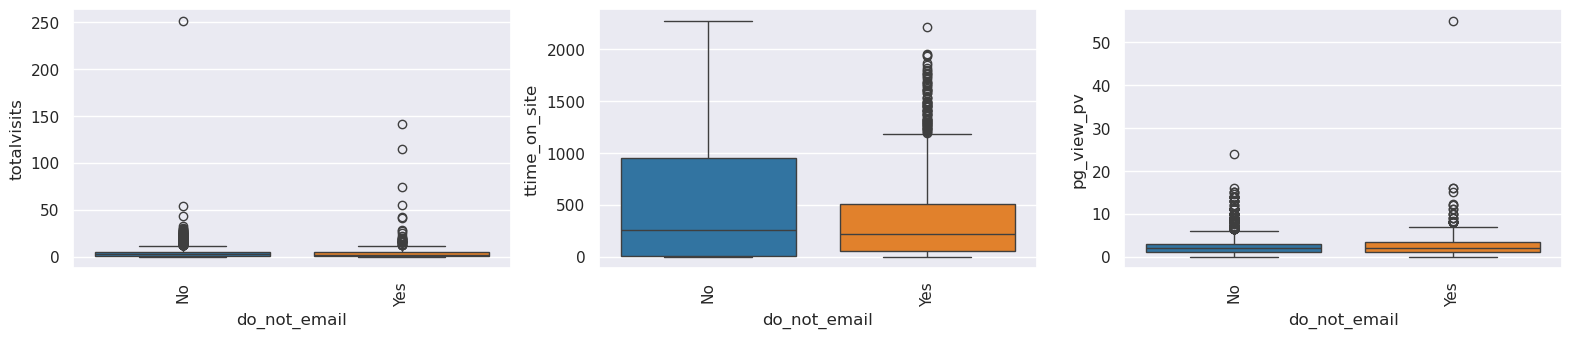

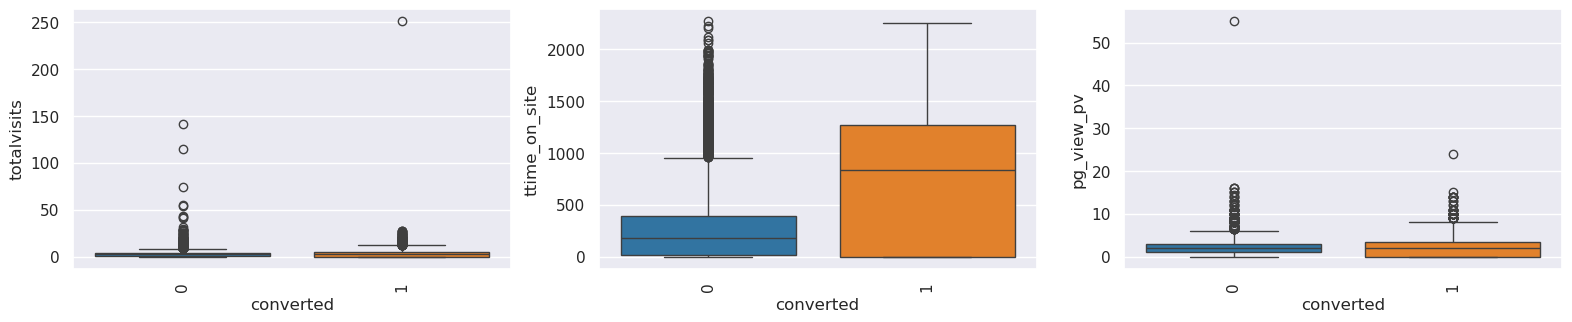

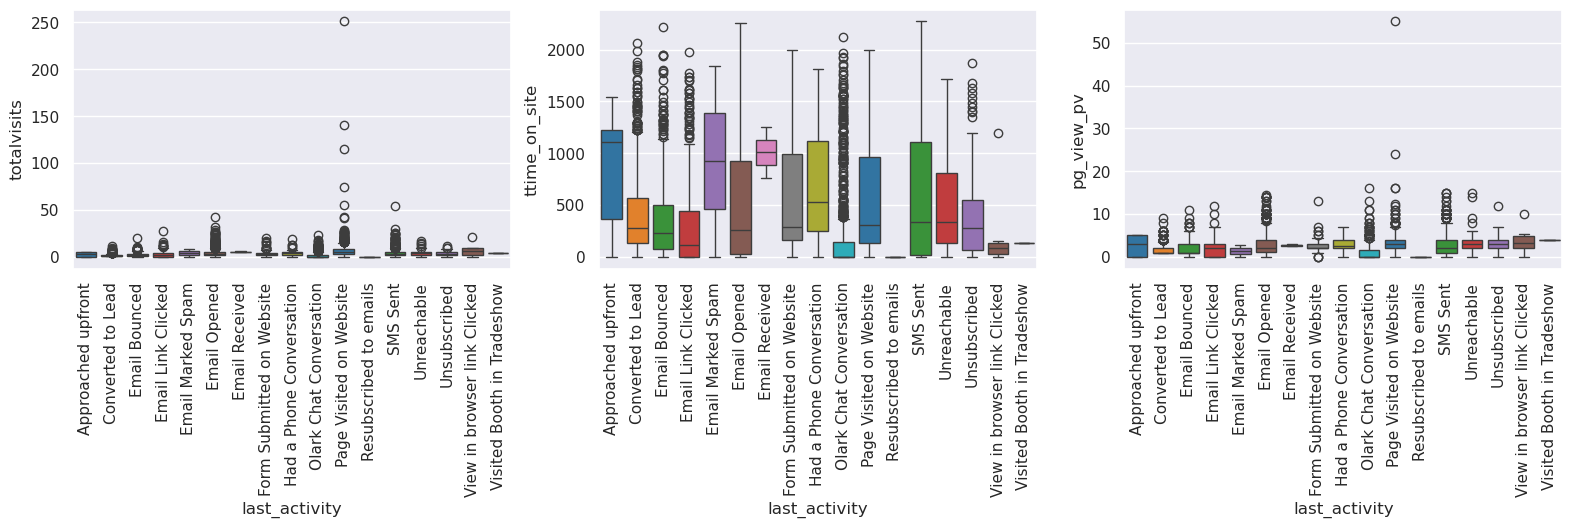

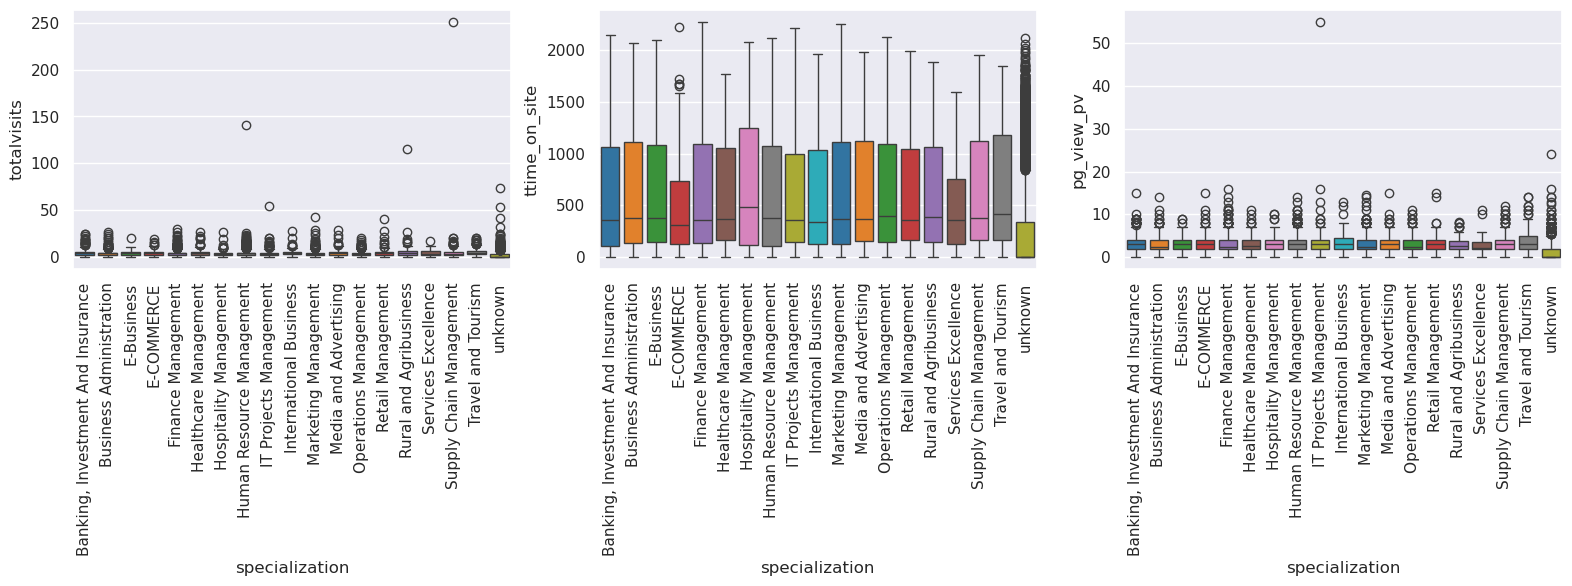

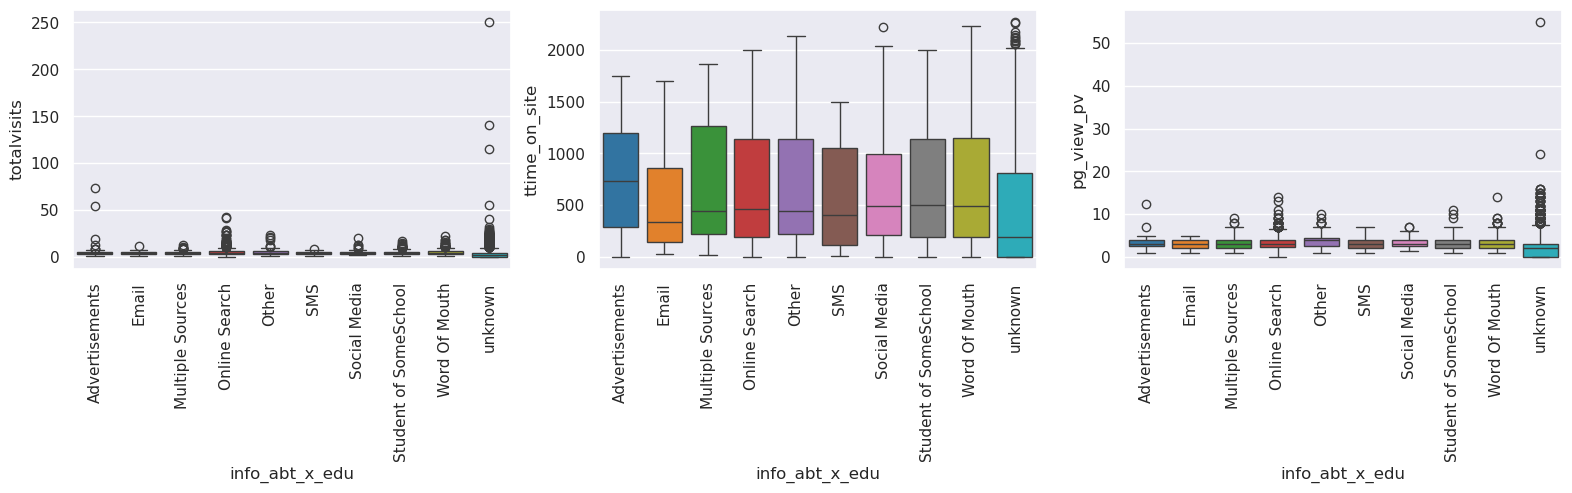

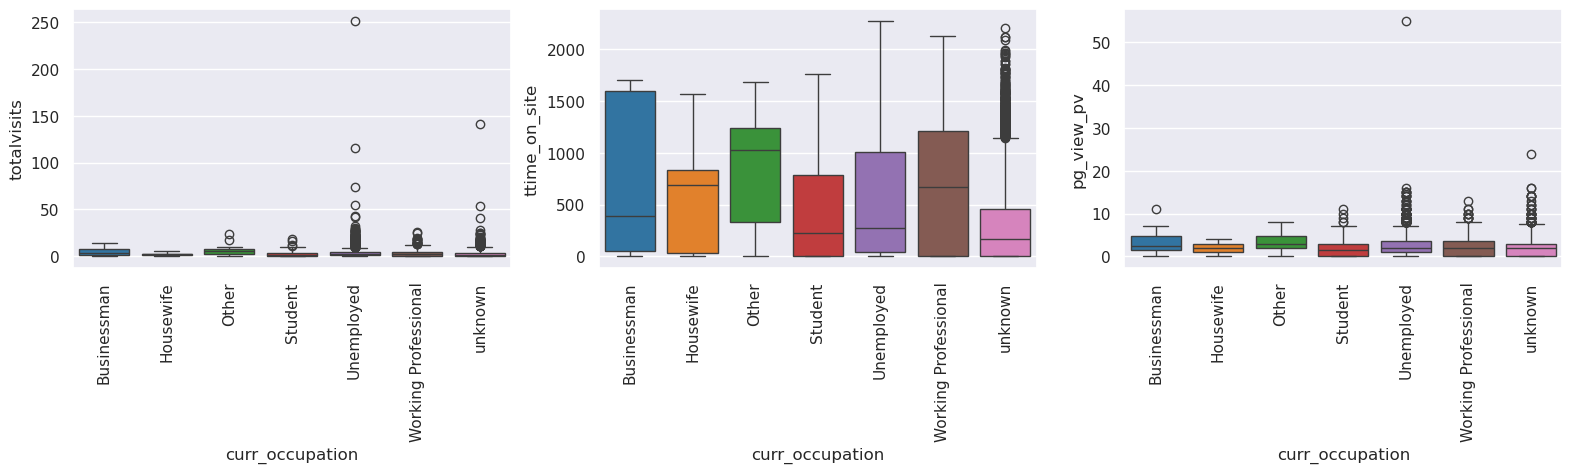

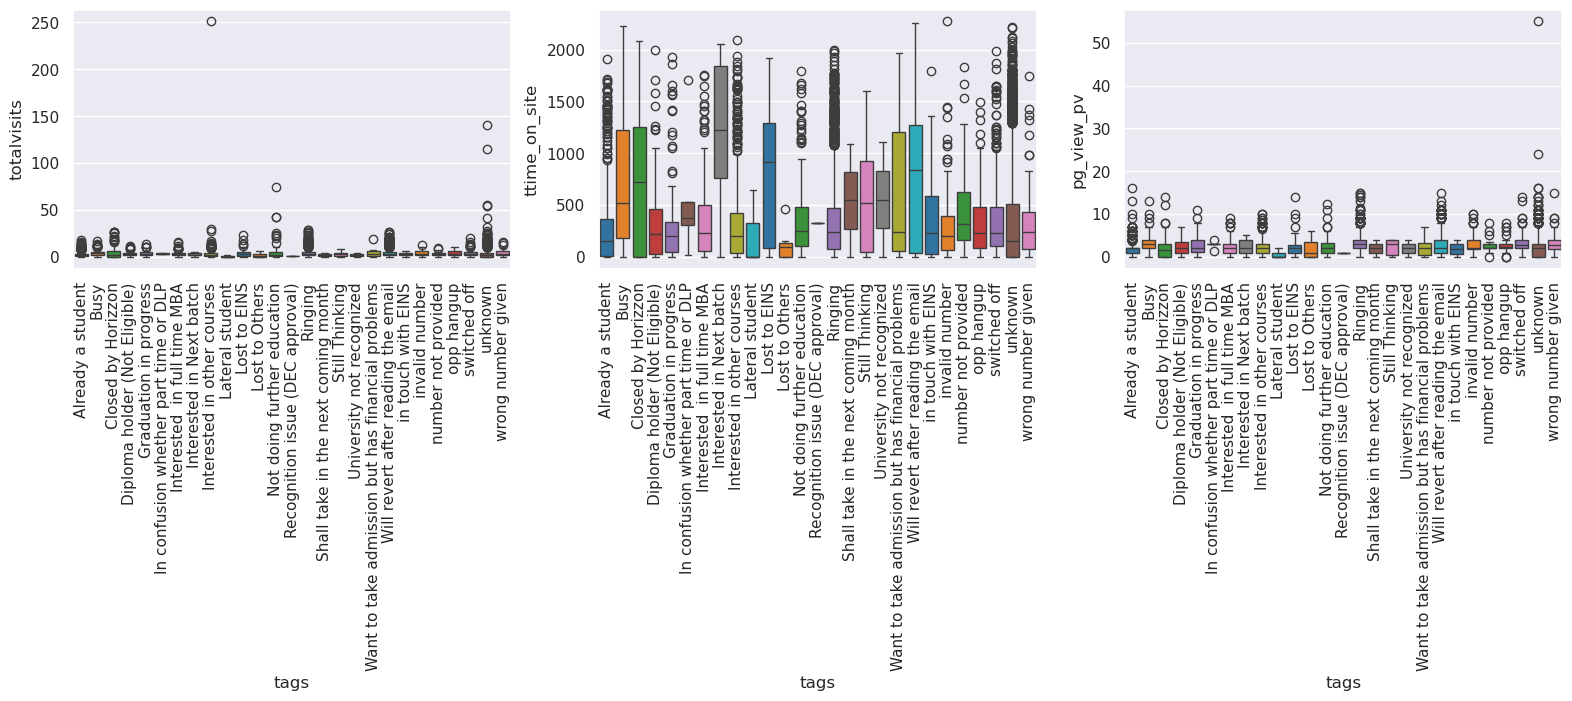

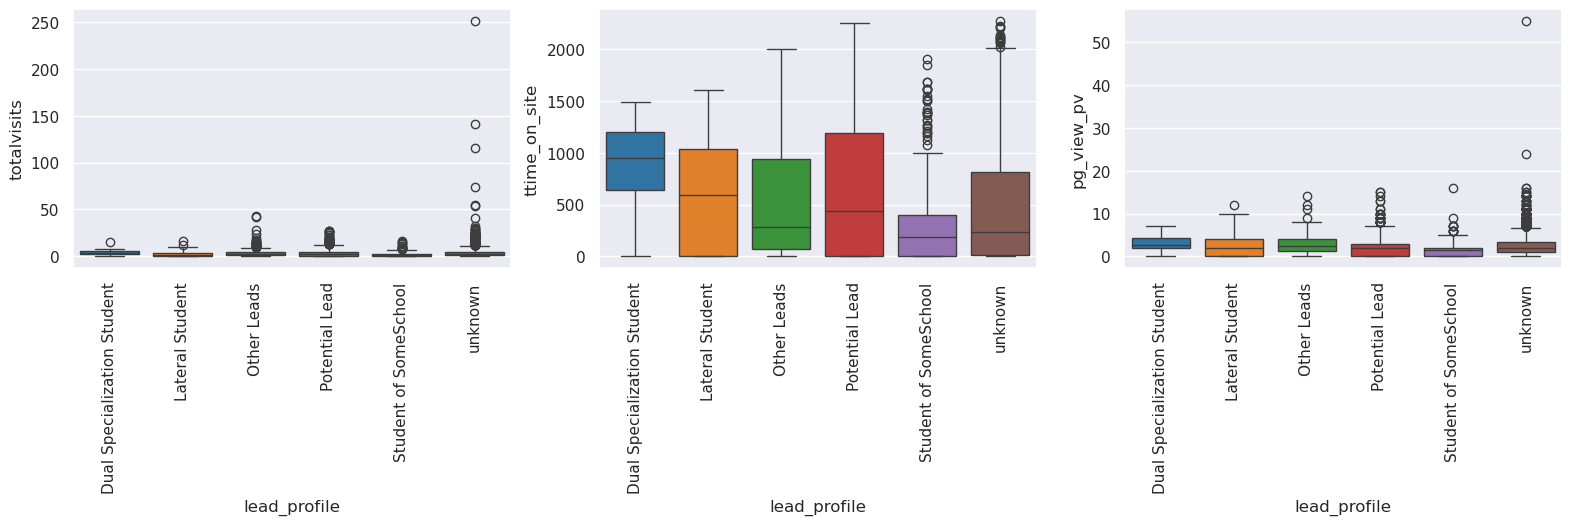

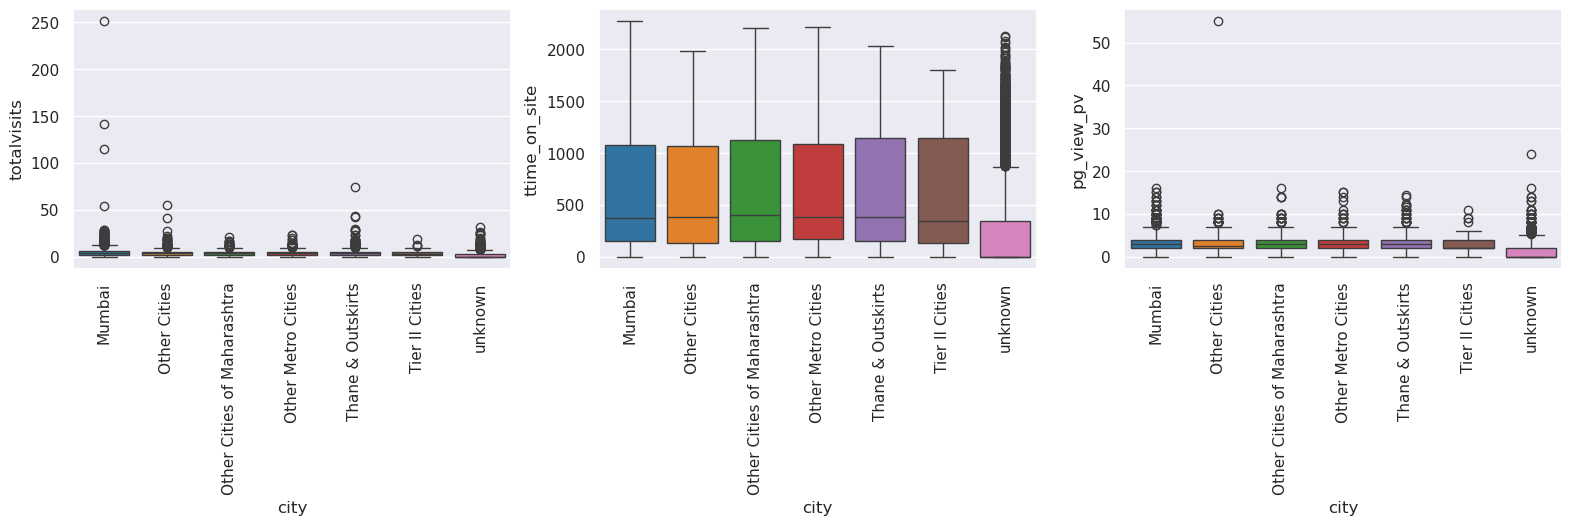

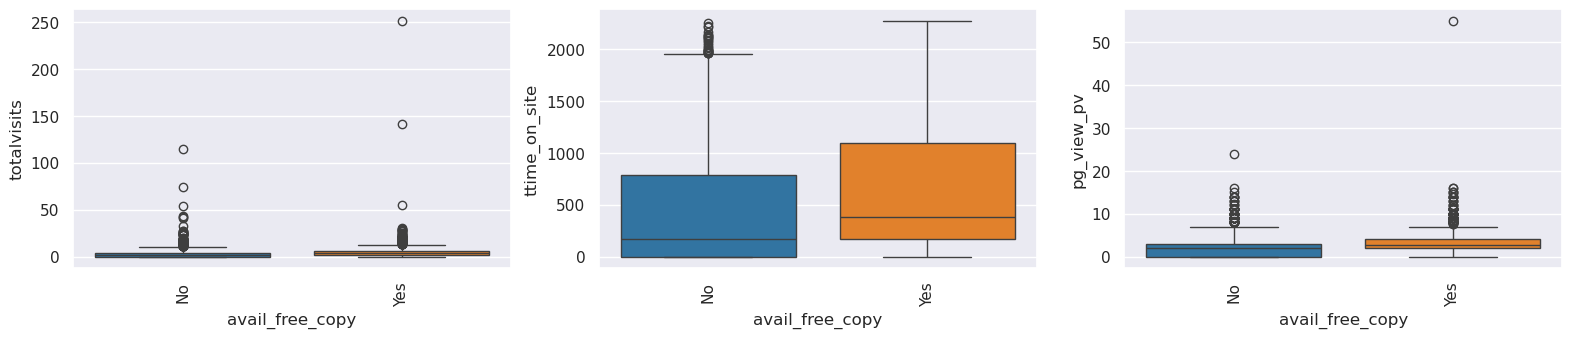

In [29]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns

x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 
axs = 1
for x_col in x_lst:
    plt.figure(figsize=(26,72))
    for y_col in y_lst:
        plt.subplot(18,4,axs)
        sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
        plt.xticks(rotation=90)
        axs += 1
    plt.show();
    axs = 1
plt.show();

In [30]:
# # Generate Bivariate Barplots combinations for all the categorical features

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8

# y_lst = x_lst = list(set(dtype_dict['int_cat']) - set(['converted','lead_number'])) # x_list variable contains all the categorical Columns 
# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(25,400))
#     for y_col in y_lst:
        
#         # x_f = lead_score_df[x_col]
#         # y_f = lead_score_df[y_col]
            
#         # if isinstance(x_f,(object,'category')):
#         #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#         # if isinstance(y_f,(object,'category')):
#         #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
        
#         plt.subplot(60,4,axs)
#         sns.barplot(x=x_col, y=y_col, hue ='converted' ,data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         # plt.ylabel(ylabel= lead_score_df[y_col].name, labelpad=-50)
#         # plt.locator_params(tight=True)
#         axs += 1
#     plt.show();
#     axs = 1
# plt.show();

In [31]:
# # Multivariate Boxplots  - 

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8
# # matplotlib.rcParams['ytick.major.size'] = 2
# # matplotlib.rcParams['xtick.major.size'] = 2

# z_lst = x_lst = list(dtype_dict['int_cat'])
# y_lst = list(dtype_dict['float_ts'])

# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#         plt.figure(figsize=(25, 200))
#         for z_col in z_lst:
            
#             # x_f = lead_score_df[x_col]
#             # y_f = lead_score_df[y_col]
            
#             # if isinstance(x_f,(object,'category')):
#             #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#             # if isinstance(y_f,(object,'category')):
#             #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
            
#             plt.subplot(25, 2, axs)
#             sns.boxplot(x=x_col, y=y_col, hue=z_col,hue_order=lead_score_df[z_col].value_counts().head(10).index ,data=lead_score_df, palette='tab10')
#             plt.xticks(rotation=90)
#             # plt.locator_params(tight=True)
#             plt.legend(loc='best')
#             axs += 1
#         plt.show();
#     axs = 1
#     print("--------------------------------------------------------------------------")
#     # break
# plt.show();

In [32]:
# # Multivariate Boxplots  - 

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8
# # matplotlib.rcParams['ytick.major.size'] = 2
# # matplotlib.rcParams['xtick.major.size'] = 2

# x_lst = list(dtype_dict['int_cat'])
# x_lst.remove('lead_origin')
# x_lst.remove('converted')
# z_lst = y_lst= x_lst
# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#             plt.figure(figsize=(25, 500))
#             for z_col in z_lst:
#                  if (x_col != y_col) & (y_col != z_col) & (x_col != z_col):
                         
#                 #     x_f = lead_score_df[x_col]
#                 #     y_f = lead_score_df[y_col]
#                 #     if isinstance(x_f,(object,'category')):
#                 #             x_f = x_f.astype('str',copy=True).str.slice(0,10)
#                 #     if isinstance(y_f,(object,'category')):
#                 #             y_f = y_f.astype('str',copy=True).str.slice(0,10)
                            
#                     plt.subplot(100, 3, axs)
#                     sns.barplot(x=x_col, y=y_col, hue=z_col, hue_order=lead_score_df[z_col].value_counts().head(10).index, data=lead_score_df, palette='tab10')
#                     plt.xticks(rotation=90)
#                 #     plt.ylabel(labelpad=3)
#                 #     plt.locator_params.set_label_coords(-0.01, 0.5)
#                     plt.legend(loc='best')
#                     axs += 1
#             plt.show()
#             axs = 1
#     print("--------------------------------------------------------------------------")
# plt.show();

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [33]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

,thresh_low,thresh_high
name,,
converted,-1.500,2.500
totalvisits,-5.000,11.000
ttime_on_site,-1374.000,2322.000
pg_view_pv,-2.000,6.000


,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
5%,0.000,0.000,0.000,0.000
10%,0.000,0.000,0.000,0.000
20%,0.000,0.000,0.000,0.000
50%,0.000,3.000,248.000,2.000
80%,1.000,5.000,1087.200,4.000
90%,1.000,7.000,1380.000,5.000


In [34]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [35]:
lead_score_df.describe()

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.221,487.698,2.259
std,0.487,2.882,548.021,1.793
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,11.000,2272.000,6.000


In [36]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0]
lead_score_df.shape

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

(9240, 15)

In [37]:
lead_score_df = lead_score_df.dropna(subset=['last_activity','lead_source','totalvisits','pg_view_pv'])

In [38]:
# lead_score_df.to_csv('spec_tag_analysis.csv')

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0] ### there are no null values

Series([], dtype: float64)

In [39]:
lead_score_df.shape
lead_score_df.dtypes

(9074, 15)

lead_origin        category
lead_source        category
do_not_email       category
converted             int64
totalvisits         float64
ttime_on_site       float64
pg_view_pv          float64
last_activity      category
specialization     category
info_abt_x_edu     category
curr_occupation    category
tags               category
lead_profile       category
city               category
avail_free_copy    category
dtype: object

In [40]:
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
# univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
# univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

In [41]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [42]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9074.000,9074.000,9074.000,9074.000
mean,0.379,3.231,482.887,2.266
std,0.485,2.881,545.257,1.791
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,11.000,1.000
50%,0.000,3.000,246.000,2.000
75%,1.000,5.000,922.750,3.200
max,1.000,11.000,2272.000,6.000


,lead_origin,lead_source,do_not_email,last_activity,specialization,info_abt_x_edu,curr_occupation,tags,lead_profile,city,avail_free_copy
count,9074,9074,9074,9074,9074,9074,9074,9074,9074,9074,9074
unique,4,21,2,17,19,10,7,27,6,7,2
top,Landing Page Submission,Google,0,Email Opened,unknown,unknown,Unemployed,unknown,unknown,unknown,0
freq,4885,2868,8358,3432,3282,7086,5476,3327,6757,3575,6186


###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [43]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

60.92%


In [44]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

37.86%


##  -----------------------------------------------------

In [45]:
# errorline # do no remove this line

## -----------------------------------------------------

## -----------------------------------------------------

## Approach - 02 (Label Encoding , Standard Scaling)

### Data Encoding

#### Label Encoding

In [ ]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = lead_score_df.select_dtypes('category').columns
cols_to_le

Index(['lead_origin', 'lead_source', 'do_not_email', 'last_activity',
       'specialization', 'info_abt_x_edu', 'curr_occupation', 'tags',
       'lead_profile', 'city', 'avail_free_copy'],
      dtype='object')

In [ ]:
df_le = lead_score_df.copy()

le = LabelEncoder()
df_le[cols_to_le] = df_le[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

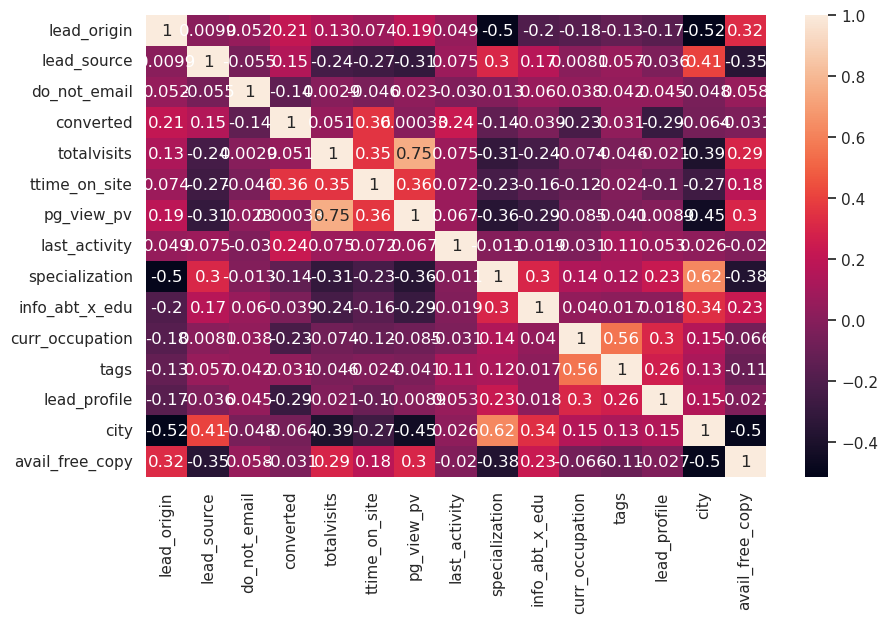

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [ ]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

# new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
# new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
df_le.head(3)

,lead_origin,lead_source,do_not_email,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,info_abt_x_edu,curr_occupation,tags,lead_profile,city,avail_free_copy
0,0,6,0,0,0.000,0.000,0.000,10,18,9,4,8,5,6,0
1,0,7,0,0,5.000,674.000,2.500,5,18,9,4,14,5,6,0
2,1,1,0,1,2.000,1532.000,2.000,5,1,9,3,19,3,0,1


In [ ]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(df_le)
null_pct[null_pct>0]
df_le.shape

Series([], dtype: float64)

(9074, 15)

In [ ]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = df_le.drop(['converted'], axis=1)
y = df_le['converted']

In [ ]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

,lead_origin,lead_source,do_not_email,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,info_abt_x_edu,curr_occupation,tags,lead_profile,city,avail_free_copy
5509,1,1,0,2.010,1.654,1.253,12,10,9,4,14,5,0,1
7746,0,7,0,0.966,-0.568,0.412,5,18,9,4,23,2,6,0
8263,1,1,0,-0.428,-0.636,-0.149,5,4,9,3,0,4,1,1
4559,1,3,0,0.269,0.708,0.973,12,14,7,5,19,5,4,0
7959,1,3,0,0.966,0.501,0.412,6,7,6,5,19,5,0,0


###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('lead_origin', True, 1),
 ('lead_source', True, 1),
 ('do_not_email', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', True, 1),
 ('last_activity', True, 1),
 ('specialization', True, 1),
 ('info_abt_x_edu', True, 1),
 ('curr_occupation', True, 1),
 ('tags', True, 1),
 ('lead_profile', True, 1),
 ('city', True, 1),
 ('avail_free_copy', True, 1)]

In [ ]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7244
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3282.1
Date:                Mon, 21 Oct 2024   Deviance:                       6564.2
Time:                        15:14:25   Pearson chi2:                 7.67e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3496
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4856      0.247      6.005      0.000       1.001       1.970
lead_origin         0.7249      0.067     10.879      0.000       0.594       0.856
lead_source         0.1571      0.013     12.360      0.000       0.132       0.182
do_not_email       -1.6018      0.148    -10.843      0.000      -1.891      -1.312
totalvisits         0.1255      0.046      2.725      0.006       0.035       0.216
ttime_on_site       1.0458      0.036     29.449      0.000       0.976       1.115
pg_view_pv         -0.4477      0.049     -9.080      0.000      -0.544      -0.351
last_activity       0.1507      0.009     16.819      0.000       0.133       0.168
specialization     -0.0303      0.007     -4.434      0.000      -0.044      -0.017
info_abt_x_edu      0.0676      0.018      3.668      0.000       0.031       0.104
curr_occupation    -0.6399      0.041    -15.612      0.000      -0.720      -0.560
tags                0.0716      0.005     14.996      0.000       0.062       0.081
lead_profile       -0.5938      0.034    -17.686      0.000      -0.660      -0.528
city                0.0059      0.018      0.322      0.747      -0.030       0.042
avail_free_copy    -0.5310      0.095     -5.610      0.000      -0.716      -0.345
===================================================================================
"""


VIF Score:


,Features,VIF
9,curr_occupation,28.030
11,lead_profile,21.330
8,info_abt_x_edu,19.910
7,specialization,8.580
10,tags,8.210
12,city,5.950
6,last_activity,5.430
1,lead_source,4.430
0,lead_origin,3.380
13,avail_free_copy,3.030


##### Model 2

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('curr_occupation', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'info_abt_x_edu', 'tags', 'lead_profile', 'city', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7245
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3410.6
Date:                Mon, 21 Oct 2024   Deviance:                       6821.2
Time:                        15:14:25   Pearson chi2:                 7.57e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3262
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5987      0.204     -2.939      0.003      -0.998      -0.199
lead_origin         0.7676      0.065     11.849      0.000       0.641       0.895
lead_source         0.1574      0.012     12.659      0.000       0.133       0.182
do_not_email       -1.5405      0.144    -10.664      0.000      -1.824      -1.257
totalvisits         0.1097      0.045      2.437      0.015       0.021       0.198
ttime_on_site       1.0588      0.035     30.405      0.000       0.991       1.127
pg_view_pv         -0.4064      0.048     -8.444      0.000      -0.501      -0.312
last_activity       0.1610      0.009     18.213      0.000       0.144       0.178
specialization     -0.0289      0.007     -4.275      0.000      -0.042      -0.016
info_abt_x_edu      0.0764      0.018      4.212      0.000       0.041       0.112
tags                0.0353      0.004      8.619      0.000       0.027       0.043
lead_profile       -0.6772      0.033    -20.418      0.000      -0.742      -0.612
city               -0.0046      0.018     -0.252      0.801      -0.040       0.031
avail_free_copy    -0.5807      0.093     -6.228      0.000      -0.763      -0.398
===================================================================================
"""


VIF Score:


,Features,VIF
8,info_abt_x_edu,18.350
10,lead_profile,16.280
7,specialization,8.560
9,tags,6.050
11,city,5.950
6,last_activity,5.430
1,lead_source,4.430
0,lead_origin,3.310
12,avail_free_copy,3.030
5,pg_view_pv,2.550


##### Model 3

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('info_abt_x_edu', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'tags', 'lead_profile', 'city', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7246
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3419.5
Date:                Mon, 21 Oct 2024   Deviance:                       6839.1
Time:                        15:14:25   Pearson chi2:                 7.61e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3245
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1400      0.172     -0.815      0.415      -0.477       0.197
lead_origin         0.7297      0.064     11.454      0.000       0.605       0.855
lead_source         0.1646      0.012     13.350      0.000       0.140       0.189
do_not_email       -1.5002      0.144    -10.419      0.000      -1.782      -1.218
totalvisits         0.0962      0.045      2.143      0.032       0.008       0.184
ttime_on_site       1.0542      0.035     30.301      0.000       0.986       1.122
pg_view_pv         -0.4274      0.048     -8.921      0.000      -0.521      -0.333
last_activity       0.1604      0.009     18.189      0.000       0.143       0.178
specialization     -0.0247      0.007     -3.705      0.000      -0.038      -0.012
tags                0.0354      0.004      8.652      0.000       0.027       0.043
lead_profile       -0.6855      0.033    -20.725      0.000      -0.750      -0.621
city                0.0170      0.017      0.977      0.329      -0.017       0.051
avail_free_copy    -0.3572      0.077     -4.662      0.000      -0.507      -0.207
===================================================================================
"""


VIF Score:


,Features,VIF
9,lead_profile,14.490
7,specialization,8.040
8,tags,6.000
10,city,5.370
6,last_activity,5.330
1,lead_source,4.260
0,lead_origin,3.280
5,pg_view_pv,2.530
3,totalvisits,2.390
11,avail_free_copy,2.030


##### Model 4

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('lead_profile', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'tags', 'city', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7247
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3653.8
Date:                Mon, 21 Oct 2024   Deviance:                       7307.5
Time:                        15:14:25   Pearson chi2:                 7.46e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2795
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.3354      0.137    -17.071      0.000      -2.604      -2.067
lead_origin         0.7072      0.061     11.588      0.000       0.588       0.827
lead_source         0.1788      0.012     14.975      0.000       0.155       0.202
do_not_email       -1.5025      0.140    -10.767      0.000      -1.776      -1.229
totalvisits         0.0893      0.044      2.044      0.041       0.004       0.175
ttime_on_site       1.0558      0.034     31.261      0.000       0.990       1.122
pg_view_pv         -0.4647      0.046    -10.017      0.000      -0.556      -0.374
last_activity       0.1409      0.008     16.843      0.000       0.124       0.157
specialization     -0.0460      0.006     -7.253      0.000      -0.058      -0.034
tags                0.0136      0.004      3.636      0.000       0.006       0.021
city               -0.0082      0.017     -0.493      0.622      -0.041       0.024
avail_free_copy    -0.4357      0.073     -5.929      0.000      -0.580      -0.292
===================================================================================
"""


VIF Score:


,Features,VIF
7,specialization,6.510
9,city,5.200
6,last_activity,4.920
8,tags,4.820
1,lead_source,4.260
0,lead_origin,2.990
5,pg_view_pv,2.510
3,totalvisits,2.390
10,avail_free_copy,1.880
4,ttime_on_site,1.220


##### Model 5

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('city', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'tags', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7248
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3653.9
Date:                Mon, 21 Oct 2024   Deviance:                       7307.8
Time:                        15:14:25   Pearson chi2:                 7.45e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2795
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.3487      0.134    -17.501      0.000      -2.612      -2.086
lead_origin         0.7176      0.057     12.526      0.000       0.605       0.830
lead_source         0.1773      0.012     15.368      0.000       0.155       0.200
do_not_email       -1.5026      0.140    -10.765      0.000      -1.776      -1.229
totalvisits         0.0910      0.044      2.090      0.037       0.006       0.176
ttime_on_site       1.0558      0.034     31.273      0.000       0.990       1.122
pg_view_pv         -0.4619      0.046    -10.035      0.000      -0.552      -0.372
last_activity       0.1407      0.008     16.841      0.000       0.124       0.157
specialization     -0.0470      0.006     -7.866      0.000      -0.059      -0.035
tags                0.0136      0.004      3.629      0.000       0.006       0.021
avail_free_copy    -0.4286      0.072     -5.948      0.000      -0.570      -0.287
===================================================================================
"""


VIF Score:


,Features,VIF
7,specialization,4.900
6,last_activity,4.820
8,tags,4.750
1,lead_source,3.900
0,lead_origin,2.750
5,pg_view_pv,2.490
3,totalvisits,2.370
9,avail_free_copy,1.840
4,ttime_on_site,1.220
2,do_not_email,1.100


##### Model 6

In [ ]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('totalvisits', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'ttime_on_site',
       'pg_view_pv', 'last_activity', 'specialization', 'tags',
       'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7249
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3656.1
Date:                Mon, 21 Oct 2024   Deviance:                       7312.1
Time:                        15:14:25   Pearson chi2:                 7.46e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2790
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.3425      0.134    -17.473      0.000      -2.605      -2.080
lead_origin         0.7092      0.057     12.404      0.000       0.597       0.821
lead_source         0.1785      0.012     15.477      0.000       0.156       0.201
do_not_email       -1.5025      0.140    -10.754      0.000      -1.776      -1.229
ttime_on_site       1.0623      0.034     31.576      0.000       0.996       1.128
pg_view_pv         -0.3987      0.035    -11.543      0.000      -0.466      -0.331
last_activity       0.1409      0.008     16.884      0.000       0.125       0.157
specialization     -0.0479      0.006     -8.026      0.000      -0.060      -0.036
tags                0.0134      0.004      3.599      0.000       0.006       0.021
avail_free_copy    -0.4112      0.072     -5.745      0.000      -0.552      -0.271
===================================================================================
"""


VIF Score:


,Features,VIF
6,specialization,4.880
5,last_activity,4.810
7,tags,4.750
1,lead_source,3.880
0,lead_origin,2.730
8,avail_free_copy,1.810
4,pg_view_pv,1.330
3,ttime_on_site,1.210
2,do_not_email,1.100



Confusion Matrix:


array([[3852,  600],
       [1091, 1716]])


Accuracy Score: 0.7670478027276484



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.6113288208051301

0.8652291105121294

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,1,0.688,5509,1,1,1,1,1,1,1,1,0,0,0
1,0,0.153,7746,0,1,1,0,0,0,0,0,0,0,0
2,0,0.122,8263,0,1,1,0,0,0,0,0,0,0,0
3,1,0.632,4559,1,1,1,1,1,1,1,1,0,0,0
4,1,0.509,7959,1,1,1,1,1,1,1,0,0,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.387  1.000  0.000
0.100 0.100     0.481  0.983  0.165
0.200 0.200     0.632  0.896  0.465
0.300 0.300     0.751  0.817  0.710
0.400 0.400     0.768  0.701  0.810
0.500 0.500     0.767  0.611  0.865
0.600 0.600     0.753  0.510  0.906
0.700 0.700     0.726  0.389  0.939
0.800 0.800     0.685  0.242  0.965
0.900 0.900     0.638  0.077  0.992


<Axes: xlabel='prob'>

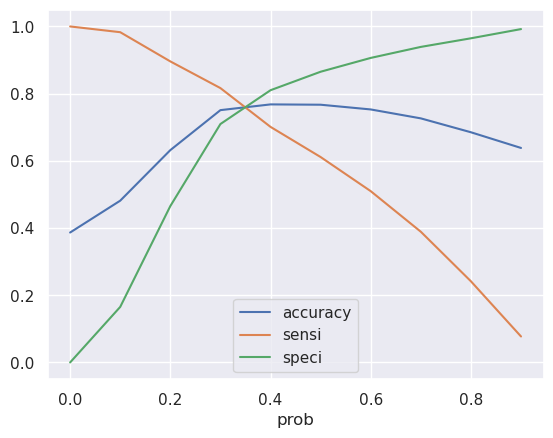

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.36 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,1,0.688,5509,1,1,1,1,1,1,1,1,0,0,0,1
1,0,0.153,7746,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.122,8263,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0.632,4559,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.509,7959,1,1,1,1,1,1,1,0,0,0,0,1


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7642926022868164

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3435, 1017],
       [ 694, 2113]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.7527609547559673

0.7715633423180593

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

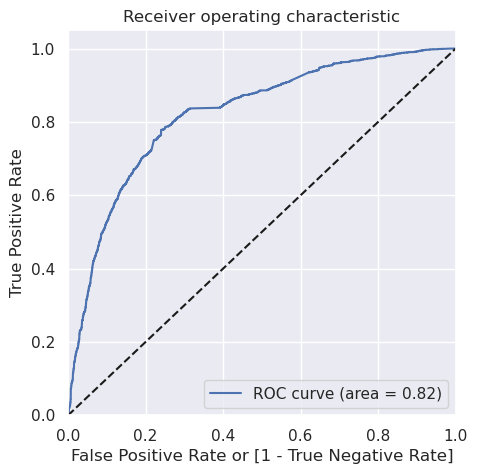

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7409326424870466

0.6113288208051301

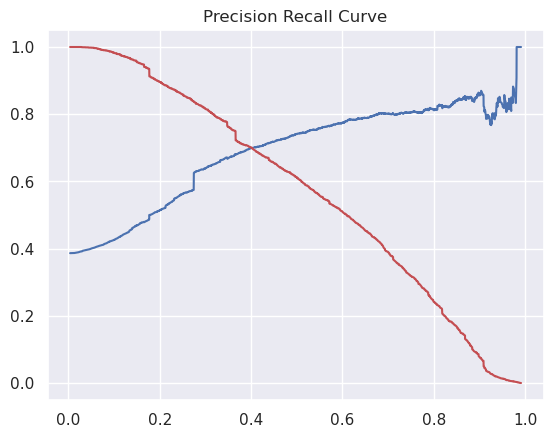

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.40 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,1,0.688,5509,1,1,1,1,1,1,1,1,0,0,0,1
1,0,0.153,7746,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.122,8263,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0.632,4559,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.509,7959,1,1,1,1,1,1,1,0,0,0,0,1


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7680121228819397

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3607,  845],
       [ 839, 1968]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7011043819023869

0.8101976639712489

0.7409326424870466

0.6113288208051301

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,lead_origin,lead_source,do_not_email,ttime_on_site,pg_view_pv,last_activity,specialization,tags,avail_free_copy
3374,1,1,0,-0.779,0.412,12,8,25,1
4262,0,6,0,-0.895,-1.270,5,18,25,0
7855,0,3,0,-0.743,0.412,9,18,25,0
3017,1,3,0,1.256,0.973,3,16,25,0
560,0,6,0,1.649,-0.334,5,0,19,1


In [ ]:
cutoff = 0.40
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[976, 211],
       [182, 446]])


Accuracy Score: 0.7834710743801653



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7101910828025477

0.8222409435551812

0.7409326424870466

0.6113288208051301

## Approach - 02 - Accuracy Score:

In [ ]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.7834710743801653



## -----------------------------------------------------

In [ ]:
# errorline #do not remove

## -----------------------------------------------------

## Approach - 03 (Dummy Encoding, MinMax scaling)

### Data Encoding

#### Dummy Encoding

In [ ]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

new_ls_df = pd.get_dummies(new_ls_df, columns=['tags', 'specialization', 'info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation'], dtype=float)
new_ls_df = new_ls_df.drop(new_ls_df.filter(like='unknown',axis=1).columns, axis=1)
new_ls_df.shape

,converted,totalvisits,ttime_on_site,pg_view_pv,specialization,info_abt_x_edu,curr_occupation,tags,lead_profile,city,avail_free_copy_1,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel
0,0,0.000,0.000,0.000,unknown,unknown,Unemployed,Interested in other courses,unknown,unknown,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


(9074, 52)

(9074, 116)

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [ ]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
do_not_email_1                                            float64
last_activity_Converted to Lead                           float64
last_activity_Email Bounced                               float64
last_activity_Email Link Clicked                          float64
last_activity_Email Marked Spam                           float64
last_activity_Email Opened                                float64
last_activity_Email Received                              float64
last_activity_Form Submitted on Website                   float64
last_activity_Had a Phone Conversation                    float64
last_activity_Olark Chat Conversation                     float64
last_activ

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

['totalvisits', 'ttime_on_site', 'pg_view_pv']

,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,info_abt_x_edu_Advertisements,info_abt_x_edu_Email,info_abt_x_edu_Multiple Sources,info_abt_x_edu_Online Search,info_abt_x_edu_Other,info_abt_x_edu_SMS,info_abt_x_edu_Social Media,info_abt_x_edu_Student of SomeSchool,info_abt_x_edu_Word Of Mouth,lead_profile_Dual Specialization Student,lead_profile_Lateral Student,lead_profile_Other Leads,lead_profile_Potential Lead,lead_profile_Student of SomeSchool,city_Mumbai,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Businessman,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional
5509,0.818,0.612,0.750,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
7746,0.545,0.078,0.500,0.000,0.000,0.000,0.000,0.0

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('ttime_on_site', True, 1),
 ('lead_source_Welingak Website', True, 1),
 ('tags_Already a student', True, 1),
 ('tags_Closed by Horizzon', True, 1),
 ('tags_Diploma holder (Not Eligible)', True, 1),
 ('tags_Interested  in full time MBA', True, 1),
 ('tags_Interested in other courses', True, 1),
 ('tags_Lost to EINS', True, 1),
 ('tags_Not doing further education', True, 1),
 ('tags_Ringing', True, 1),
 ('tags_Will revert after reading the email', True, 1),
 ('tags_invalid number', True, 1),
 ('tags_number not provided', True, 1),
 ('tags_switched off', True, 1),
 ('tags_wrong number given', True, 1)]

In [ ]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7243
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1829.1
Date:                Mon, 21 Oct 2024   Deviance:                       3658.2
Time:                        15:14:35   Pearson chi2:                 7.35e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5642
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.9684      0.065    -30.482      0.000      -2.095      -1.842
ttime_on_site                                3.8116      0.179     21.257      0.000       3.460       4.163
lead_source_Welingak Website                 5.6418      0.719      7.849      0.000       4.233       7.051
tags_Already a student                      -4.1439      0.714     -5.804      0.000      -5.543      -2.745
tags_Closed by Horizzon                      6.1933      0.714      8.678      0.000       4.794       7.592
tags_Diploma holder (Not Eligible)          -3.0951      1.031     -3.002      0.003      -5.116      -1.075
tags_Interested  in full time MBA           -2.8452      0.727     -3.911      0.000      -4.271      -1.419
tags_Interested in other courses            -2.6106      0.318     -8.209      0.000      -3.234      -1.987
tags_Lost to EINS                            4.5305      0.516      8.779      0.000       3.519       5.542
tags_Not doing further education            -3.8225      1.012     -3.777      0.000      -5.806      -1.839
tags_Ringing                                -2.4888      0.195    -12.775      0.000      -2.871      -2.107
tags_Will revert after reading the email     4.6586      0.160     29.165      0.000       4.346       4.972
tags_invalid number                         -3.2148      1.032     -3.116      0.002      -5.237      -1.193
tags_number not provided                   -23.7806    2.7e+04     -0.001      0.999    -5.3e+04     5.3e+04
tags_switched off                           -3.2570      0.592     -5.500      0.000      -4.418      -2.096
tags_wrong number given                    -23.5846   2.13e+04     -0.001      0.999   -4.17e+04    4.17e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.600
10,tags_Will revert after reading the email,1.380
9,tags_Ringing,1.070
3,tags_Closed by Horizzon,1.040
7,tags_Lost to EINS,1.040
2,tags_Already a student,1.020
6,tags_Interested in other courses,1.020
1,lead_source_Welingak Website,1.010
5,tags_Interested in full time MBA,1.010
8,tags_Not doing further education,1.010


##### Model 2

In [ ]:
col = col.drop('tags_number not provided', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Diploma holder (Not Eligible)',
       'tags_Interested  in full time MBA', 'tags_Interested in other courses',
       'tags_Lost to EINS', 'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off', 'tags_wrong number given'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7244
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1836.6
Date:                Mon, 21 Oct 2024   Deviance:                       3673.3
Time:                        15:14:35   Pearson chi2:                 7.35e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5633
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.9760      0.065    -30.615      0.000      -2.103      -1.850
ttime_on_site                                3.7900      0.179     21.211      0.000       3.440       4.140
lead_source_Welingak Website                 5.6495      0.719      7.860      0.000       4.241       7.058
tags_Already a student                      -4.1284      0.714     -5.783      0.000      -5.528      -2.729
tags_Closed by Horizzon                      6.2026      0.714      8.691      0.000       4.804       7.601
tags_Diploma holder (Not Eligible)          -3.0781      1.031     -2.987      0.003      -5.098      -1.058
tags_Interested  in full time MBA           -2.8296      0.727     -3.891      0.000      -4.255      -1.404
tags_Interested in other courses            -2.5945      0.318     -8.163      0.000      -3.217      -1.972
tags_Lost to EINS                            4.5414      0.516      8.801      0.000       3.530       5.553
tags_Not doing further education            -3.8064      1.012     -3.761      0.000      -5.790      -1.823
tags_Ringing                                -2.4725      0.195    -12.702      0.000      -2.854      -2.091
tags_Will revert after reading the email     4.6690      0.160     29.238      0.000       4.356       4.982
tags_invalid number                         -3.1987      1.031     -3.102      0.002      -5.220      -1.178
tags_switched off                           -3.2406      0.592     -5.473      0.000      -4.401      -2.080
tags_wrong number given                    -22.5691   1.29e+04     -0.002      0.999   -2.53e+04    2.53e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.590
10,tags_Will revert after reading the email,1.380
9,tags_Ringing,1.070
3,tags_Closed by Horizzon,1.040
7,tags_Lost to EINS,1.040
2,tags_Already a student,1.020
6,tags_Interested in other courses,1.020
1,lead_source_Welingak Website,1.010
5,tags_Interested in full time MBA,1.010
8,tags_Not doing further education,1.010


##### Model 3

In [ ]:
col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Diploma holder (Not Eligible)',
       'tags_Interested  in full time MBA', 'tags_Interested in other courses',
       'tags_Lost to EINS', 'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7245
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1846.8
Date:                Mon, 21 Oct 2024   Deviance:                       3693.7
Time:                        15:14:35   Pearson chi2:                 7.37e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5621
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.9899      0.064    -30.858      0.000      -2.116      -1.864
ttime_on_site                                3.7731      0.178     21.200      0.000       3.424       4.122
lead_source_Welingak Website                 5.6634      0.719      7.879      0.000       4.255       7.072
tags_Already a student                      -4.1084      0.714     -5.756      0.000      -5.507      -2.709
tags_Closed by Horizzon                      6.2177      0.714      8.712      0.000       4.819       7.617
tags_Diploma holder (Not Eligible)          -3.0569      1.030     -2.967      0.003      -5.076      -1.038
tags_Interested  in full time MBA           -2.8095      0.727     -3.864      0.000      -4.235      -1.384
tags_Interested in other courses            -2.5739      0.318     -8.102      0.000      -3.197      -1.951
tags_Lost to EINS                            4.5578      0.516      8.834      0.000       3.547       5.569
tags_Not doing further education            -3.7858      1.012     -3.741      0.000      -5.769      -1.803
tags_Ringing                                -2.4519      0.195    -12.606      0.000      -2.833      -2.071
tags_Will revert after reading the email     4.6852      0.160     29.347      0.000       4.372       4.998
tags_invalid number                         -3.1783      1.031     -3.083      0.002      -5.199      -1.158
tags_switched off                           -3.2198      0.592     -5.439      0.000      -4.380      -2.060
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.590
10,tags_Will revert after reading the email,1.380
9,tags_Ringing,1.070
3,tags_Closed by Horizzon,1.040
7,tags_Lost to EINS,1.040
2,tags_Already a student,1.020
6,tags_Interested in other courses,1.020
1,lead_source_Welingak Website,1.010
5,tags_Interested in full time MBA,1.010
8,tags_Not doing further education,1.010



Confusion Matrix:


array([[4243,  209],
       [ 542, 2265]])


Accuracy Score: 0.8965422234467557



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8069112931955825

0.9530548068283917

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,1,0.106,5509,0,1,1,0,0,0,0,0,0,0,0
1,0,0.155,7746,0,1,1,0,0,0,0,0,0,0,0
2,0,0.003,8263,0,1,0,0,0,0,0,0,0,0,0
3,1,0.984,4559,1,1,1,1,1,1,1,1,1,1,1
4,1,0.981,7959,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.387  1.000  0.000
0.100 0.100     0.667  0.985  0.466
0.200 0.200     0.876  0.895  0.863
0.300 0.300     0.905  0.876  0.923
0.400 0.400     0.903  0.848  0.937
0.500 0.500     0.897  0.807  0.953
0.600 0.600     0.895  0.771  0.974
0.700 0.700     0.890  0.743  0.983
0.800 0.800     0.890  0.735  0.987
0.900 0.900     0.890  0.734  0.988


<Axes: xlabel='prob'>

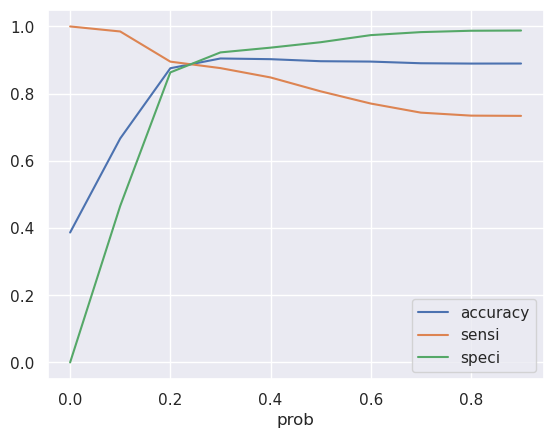

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.22 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,1,0.106,5509,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.155,7746,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.003,8263,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.984,4559,1,1,1,1,1,1,1,1,1,1,1,1
4,1,0.981,7959,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.890205262432842

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3963,  489],
       [ 308, 2499]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8902743142144638

0.8901617250673854

#### ROC Curve and Precision - Recall Curve

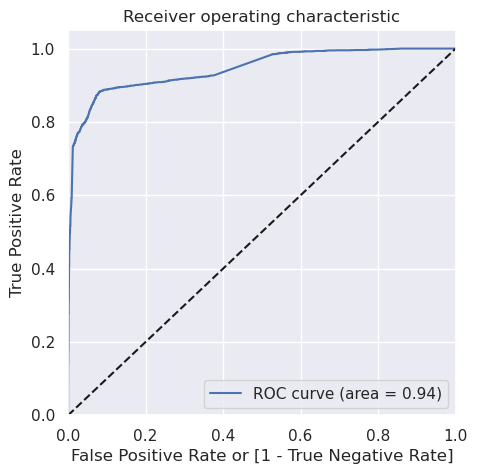

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9155214227970897

0.8069112931955825

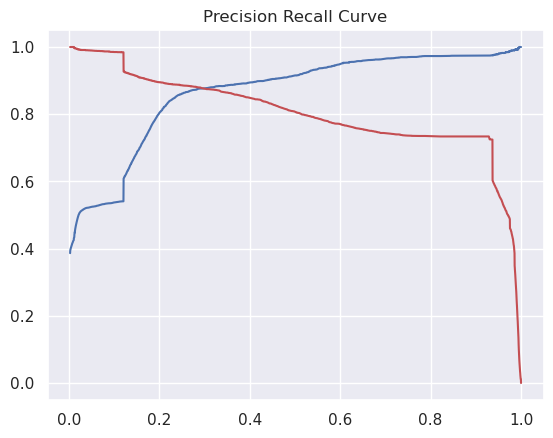

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,1,0.106,5509,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.155,7746,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.003,8263,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.984,4559,1,1,1,1,1,1,1,1,1,1,1,1
4,1,0.981,7959,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9043945447031272

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4139,  313],
       [ 381, 2426]])

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8642679016743855

0.9296945193171609

0.9155214227970897

0.8069112931955825

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in 
                   range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,ttime_on_site,lead_source_Welingak Website,tags_Already a student,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Interested in full time MBA,tags_Interested in other courses,tags_Lost to EINS,tags_Not doing further education,tags_Ringing,tags_Will revert after reading the email,tags_invalid number,tags_switched off
3374,0.028,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4262,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7855,0.037,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3017,0.516,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
560,0.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000


In [ ]:
cutoff = 0.35
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7245
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1846.8
Date:                Mon, 21 Oct 2024   Deviance:                       3693.7
Time:                        15:14:36   Pearson chi2:                 7.37e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5621
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.9899      0.064    -30.858      0.000      -2.116      -1.864
ttime_on_site                                3.7731      0.178     21.200      0.000       3.424       4.122
lead_source_Welingak Website                 5.6634      0.719      7.879      0.000       4.255       7.072
tags_Already a student                      -4.1084      0.714     -5.756      0.000      -5.507      -2.709
tags_Closed by Horizzon                      6.2177      0.714      8.712      0.000       4.819       7.617
tags_Diploma holder (Not Eligible)          -3.0569      1.030     -2.967      0.003      -5.076      -1.038
tags_Interested  in full time MBA           -2.8095      0.727     -3.864      0.000      -4.235      -1.384
tags_Interested in other courses            -2.5739      0.318     -8.102      0.000      -3.197      -1.951
tags_Lost to EINS                            4.5578      0.516      8.834      0.000       3.547       5.569
tags_Not doing further education            -3.7858      1.012     -3.741      0.000      -5.769      -1.803
tags_Ringing                                -2.4519      0.195    -12.606      0.000      -2.833      -2.071
tags_Will revert after reading the email     4.6852      0.160     29.347      0.000       4.372       4.998
tags_invalid number                         -3.1783      1.031     -3.083      0.002      -5.199      -1.158
tags_switched off                           -3.2198      0.592     -5.439      0.000      -4.380      -2.060
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.560
10,tags_Will revert after reading the email,1.370
9,tags_Ringing,1.060
3,tags_Closed by Horizzon,1.050
6,tags_Interested in other courses,1.020
7,tags_Lost to EINS,1.020
2,tags_Already a student,1.010
5,tags_Interested in full time MBA,1.010
8,tags_Not doing further education,1.010
12,tags_switched off,1.010


In [ ]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1107,   80],
       [  86,  542]])


Accuracy Score: 0.9085399449035813



In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8630573248407644

0.932603201347936

0.9155214227970897

0.8069112931955825

## Approach - 03 - Accuracy Score:

In [ ]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9085399449035813

